In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Read The image

In [157]:
def ReadImage(image_path):
    try:
        original_image = cv2.imread(image_path)

        if original_image is None:
            raise FileNotFoundError(f"Error: Image not found at '{image_path}'.")

        # Check the shape of the image
        height, width, channels = original_image.shape

        print('Image Height: ', height)
        print('Image Width:  ', width)
        print('Channles:     ', channels)

        # Convert the image to RGB
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        print('Image format:  RGB')

        # Display the original image
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')
        plt.show()

        return original_image

    except Exception as e:
        print(f"An error occurred: {str(e)}")

def displayImage(img, text='image'):
    plt.imshow(img)
    plt.title(text)
    plt.axis('off')
    plt.show()

Image Height:  720
Image Width:   1280
Channles:      3
Image format:  RGB


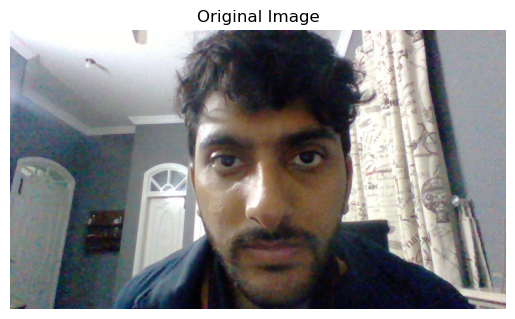

In [158]:
image = ReadImage('test_image2.jpg')


# Edges

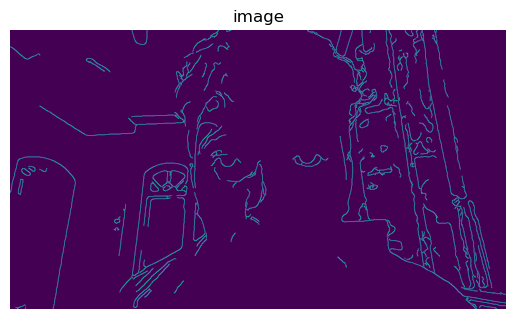

In [168]:
#frame = cv2.GaussianBlur(image, (9, 9), 0)
edges = cv2.medianBlur(image, 11)
edges = cv2.Canny(edges, 50, 150, apertureSize=3)
displayImage(edges)

In [169]:
# Importing Required Modules 
from rembg import remove 
from PIL import Image 
  
# Store path of the image in the variable input_path 
input_path =  'test_image2.jpg' 
  
# Store path of the output image in the variable output_path 
output_path = 'no_bag.png' 
  
# Processing the image 
input = Image.open(input_path) 
  
# Removing the background from the given Image 
output = remove(input) 
  
#Saving the image in the given path 
output.save(output_path) 

100%|#######################################| 176M/176M [00:00<00:00, 35.9GB/s]


Image Height:  720
Image Width:   1280
Channles:      3
Image format:  RGB


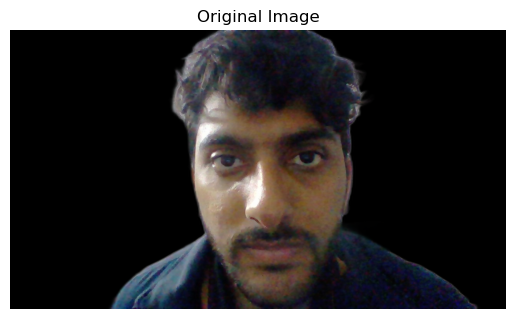

In [170]:
img = ReadImage('no_bag.png')

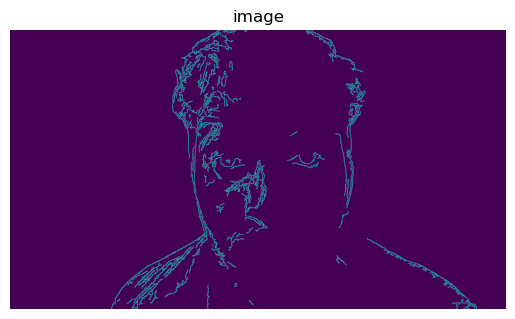

In [173]:
#frame = cv2.GaussianBlur(image, (9, 9), 0)
# edges = cv2.medianBlur(img, 1)
# edges = cv2.Canny(edges, 50, 150, apertureSize=3)
# displayImage(edges)

# Histogram_matching

In [92]:
def histogram_matching(source, target):
    # Split the images into channels
    source_channels = cv2.split(source)
    target_channels = cv2.split(target)

    matched_channels = []

    for src_channel, tgt_channel in zip(source_channels, target_channels):
        # Compute histograms
        hist_source = cv2.calcHist([src_channel], [0], None, [256], [0, 256])
        hist_target = cv2.calcHist([tgt_channel], [0], None, [256], [0, 256])

        # Normalize histograms
        hist_source /= np.sum(hist_source)
        hist_target /= np.sum(hist_target)

        # Compute cumulative distribution functions (CDFs)
        cdf_source = np.cumsum(hist_source)
        cdf_target = np.cumsum(hist_target)

        # Map pixel values from source to target using the CDFs
        mapping = np.interp(np.arange(256), cdf_source * 255, cdf_target * 255).astype(np.uint8)

        # Apply the mapping to the source channel
        matched_channel = cv2.LUT(src_channel, mapping)

        matched_channels.append(matched_channel)

    # Merge the matched channels back into a BGR image
    result_image = cv2.merge(matched_channels)

    return result_image


In [ ]:
idealImage = ReadImage("idealImage.jpg")
result_image = histogram_matching(source=image, target=idealImage)
displayImage(result_image)


# Blurr Image

In [119]:
def preprocessImage(img):
    img = cv2.edgePreservingFilter(img, flags=2, sigma_s=200, sigma_r=0.5)
    return img

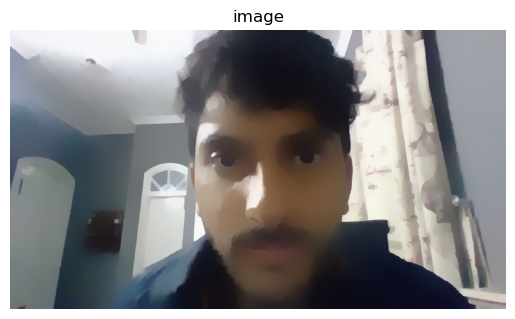

In [120]:
preprocessImage = preprocessImage(image)
displayImage(preprocessImage)

# Segment Facial Features

In [121]:
# Load the pre-trained face and eye classifiers from OpenCV
cascPath = "haarFiles/haarcascade_frontalface_default.xml"
eyePath = "haarFiles/haarcascade_eye.xml"
smilePath = "haarFiles/haarcascade_smile.xml" 
face_cascade = cv2.CascadeClassifier(cascPath)
eye_cascade = cv2.CascadeClassifier(eyePath)
smileCascade = cv2.CascadeClassifier(smilePath)
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the original image
faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.3, minNeighbors=5)

# Find the largest face based on area
largest_face = None
max_face_area = 0

for (x, y, w, h) in faces:
    face_area = w * h
    if face_area > max_face_area:
        max_face_area = face_area
        largest_face = (x, y, w, h)

# Create a black image of the same size as the original
result_img = np.zeros_like(image)

# If a face is found, process it
if largest_face is not None:
    x, y, w, h = largest_face
    
    # Extract the region of interest (ROI) from the preprocessed image
    roi_preprocessed = preprocessImage[y:y+h, x:x+w]

    # Detect eyes in the ROI of the original image
    eyes = eye_cascade.detectMultiScale(gray_img[y:y+h, x:x+w])
    
    # Find the two largest eyes based on area
    largest_eyes = sorted(eyes, key=lambda e: e[2] * e[3], reverse=True)[:2]

    # Loop over the detected eyes
    for (ex, ey, ew, eh) in largest_eyes:
        # Draw rectangles on the original image and the result image
        cv2.rectangle(image, (x + ex, y + ey), (x + ex + ew, y + ey + eh), (0, 255, 0), 2)
        # Copy the eye region from the preprocessed image to the result image
        result_img[y + ey:y + ey + eh, x + ex:x + ex + ew] = roi_preprocessed[ey:ey + eh, ex:ex + ew]

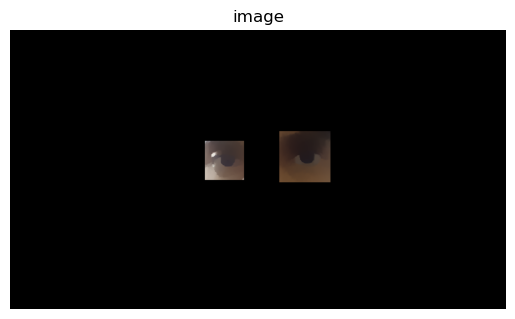

In [122]:
displayImage(result_img)

# Cartoonify eyes

In [147]:
eyes = result_img

In [154]:
def segment_sclera(eyes_image):

    # Define the lower and upper bounds for red color in RGB
    lower_red = np.array([150, 150, 150])
    upper_red = np.array([255, 255, 255])

    # Create a binary mask by applying the color threshold
    red_mask = cv2.inRange(eyes_image, lower_red, upper_red)

    plt.imshow(red_mask,cmap = 'gray')
    plt.title('Red Dots segmented')
    plt.axis('off')
    plt.show()
    # Perform  dilation to better highlight red dots
    # kernel = np.ones((4, 4), np.uint8)

    # # Perform dilation
    # red_mask = cv2.dilate(red_mask, kernel, iterations=3)
#    return red_mask

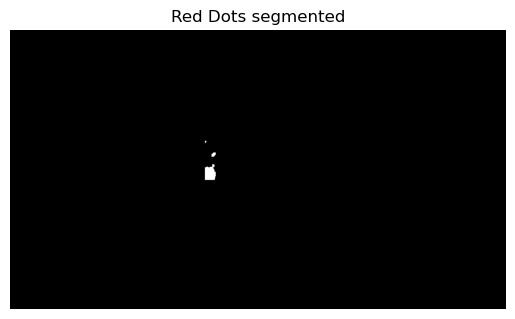

In [155]:
#segmented_sclera = segment_sclera(eyes)
segment_sclera(eyes)
#displayImage(segmented_sclera)